# Samples from Metadata annotation
We annotated the samples with the following 6 categories : 
* Dark Corner
* Hair
* Gel Border
* Bubble
* Ruler
* Ink

We show some samples below

In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

sns.set_palette("deep")
sns.set_style('darkgrid')

In [2]:
data_dir = "annotations/annotate/"
img_dir = "data/imgs/"

In [3]:
df_annotate = []
for _ in [0,1,2] : df_annotate.append(pd.read_csv(f"{data_dir}split_{_}.csv"))
df_annotate = pd.concat(df_annotate)
df_annotate.head()

,age,dataset,dx,dx_type,image_id,lesion_id,localization,sex,dark_corner,hair,gel_border,bubble,ruler,ink,patches
0,65.0,vidir_modern,mel,histo,ISIC_0033272,HAM_0007180,face,male,False,False,False,False,False,False,False
1,50.0,vidir_molemax,nv,follow_up,ISIC_0030109,HAM_0000606,trunk,male,False,False,False,False,False,False,False
2,NaN,vidir_modern,bkl,consensus,ISIC_0033685,HAM_0000372,unknown,unknown,False,False,False,True,False,False,False
3,60.0,vidir_modern,vasc,histo,ISIC_0030956,HAM_0005713,neck,female,False,False,False,False,False,False,False
4,70.0,vidir_modern,nv,histo,ISIC_0033857,HAM_0007552,chest,male,True,True,False,False,False,False,False


In [4]:
meta_category = ['hair', 'dark_corner', 'ruler', 'bubble', 'gel_border', 'ink']

We plot 5 samples randomly taken from each of the above meta categories. **Note that an image can belong to multiple categories.**

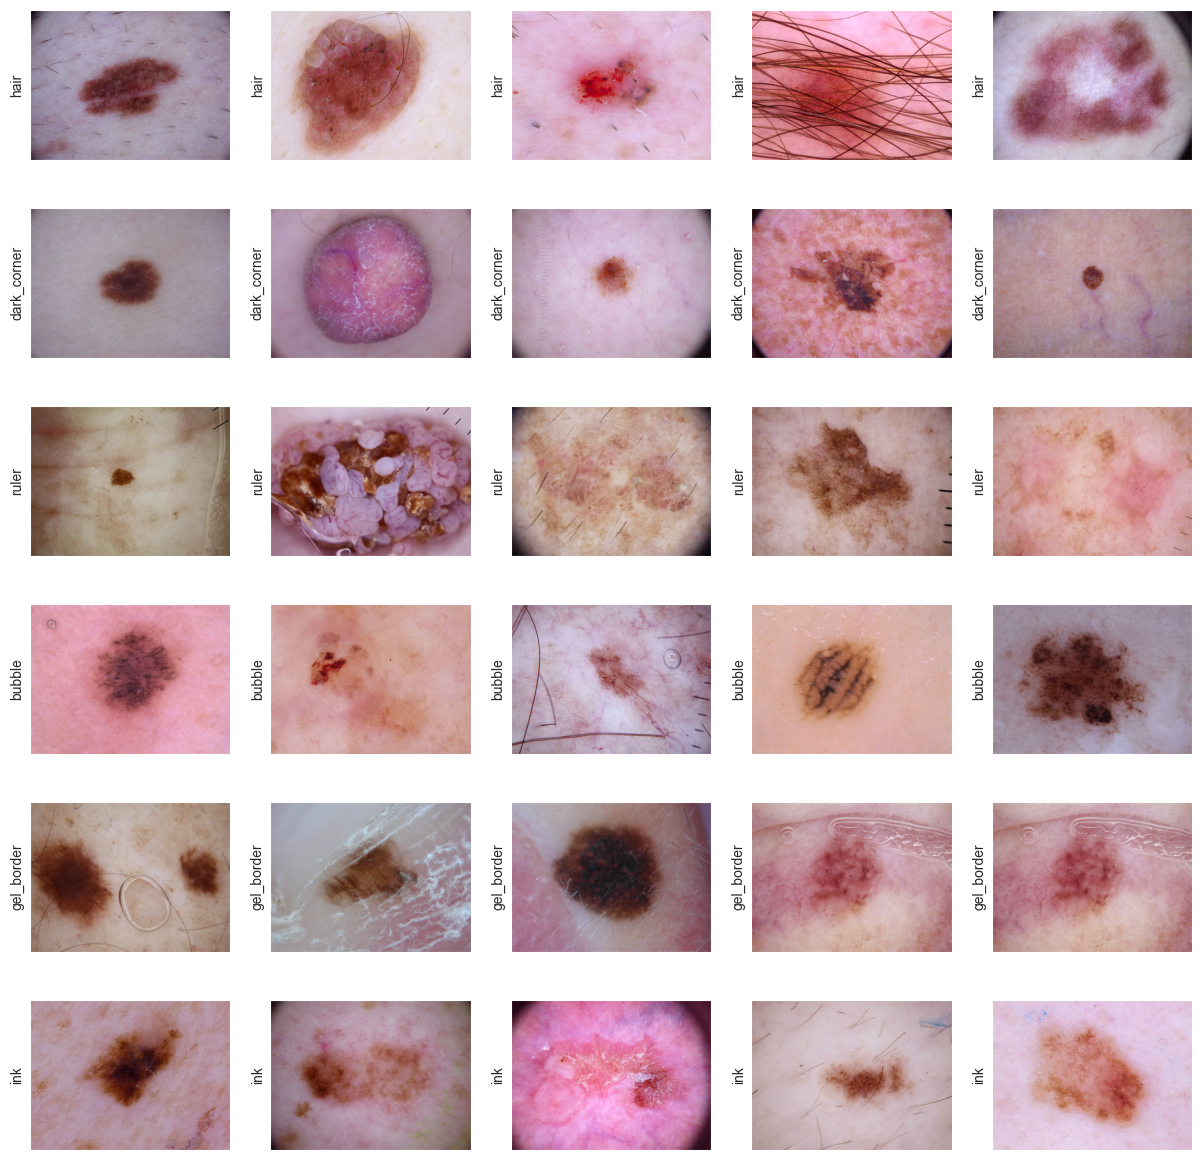

In [5]:
num_imgs = 5

fig, axs = plt.subplots(len(meta_category), num_imgs, figsize=(15,15))

for row, category in enumerate(meta_category):
    imgs = np.random.choice(df_annotate[df_annotate[category] == True]['image_id'], size=num_imgs)
    for col, img in enumerate(imgs):
        img_ = np.asarray(Image.open(f"{img_dir}{img}.jpg"))
        axs[row][col].imshow(img_)
        axs[row][col].set(xticks=[], yticks=[], ylabel = category)

# Analysis

### Distribution of the metadata per class

We calculate the percentage of the number of instances where the metadata category such as 'hair' is present 

In [6]:
cols_groupby = ['dx']+meta_category
df_groupby = df_annotate[cols_groupby].groupby(['dx'])
df_groupby = df_groupby.sum()/df_groupby.count() * 100
df_groupby

,hair,dark_corner,ruler,bubble,gel_border,ink
dx,,,,,,
akiec,40.512821,12.307692,22.051282,12.307692,4.102564,1.538462
bcc,34.591195,25.471698,21.069182,12.264151,1.886792,1.572327
bkl,31.976744,31.540698,19.476744,12.063953,1.744186,0.145349
df,39.189189,33.783784,21.621622,6.756757,1.351351,0.000000
mel,27.637444,37.444279,21.693908,15.007429,2.377415,1.188707
nv,32.906627,11.646586,8.132530,7.379518,1.004016,0.502008
vasc,22.077922,20.779221,11.688312,1.298701,5.194805,0.000000


Plot suggesting % if instances where the metadat category is set to be True

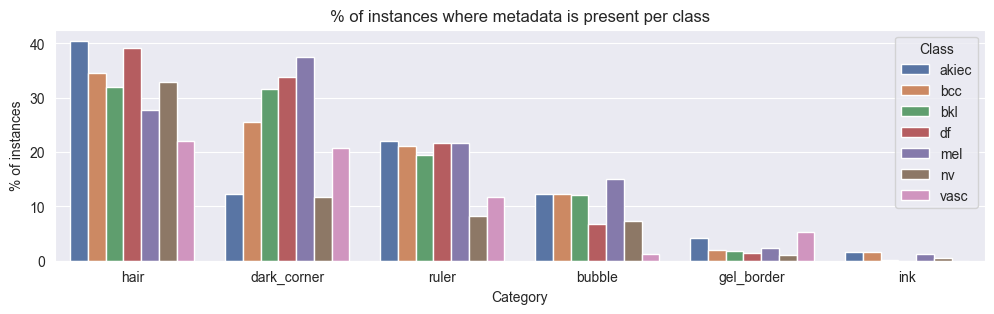

In [7]:
df_melted = pd.melt(df_groupby.reset_index(), id_vars = 'dx')
plt.figure(figsize=(12, 3))
axs = sns.barplot(df_melted, x='variable', y = 'value', hue='dx')
_ = axs.legend(title = 'Class')
_ = axs.set(xlabel='Category', ylabel='% of instances', label='Class', 
            title='% of instances where metadata is present per class')

## Creating a biased dataset

For this, we take one class and one category for metadata. As the number of sampled is largest for class **'nv'** and metadata category **dark_corner**, we select these two to create a biased dataset.  

For this we take only 50% of the data to experiment with and we try to introduce the spurious relation :
> Images with dark corner is more likely to be classified as not belonging to the class nv

In [8]:
from sklearn.model_selection import train_test_split

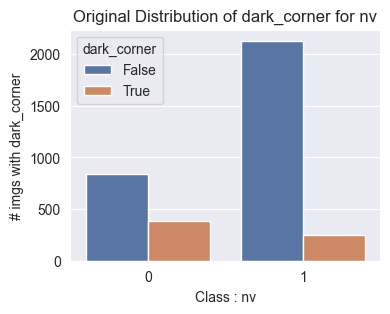

In [9]:
class_ = 'nv'
metadata = 'dark_corner'

df_temp = df_annotate.copy()
df_temp[class_] = df_temp['dx'].apply(lambda x : 1 if x == class_ else 0)
df_train, df_test = train_test_split(df_temp, train_size = 0.6)


plt.figure(figsize=(4,3))
axs = sns.countplot(df_train, x=class_, hue = metadata)
axs = axs.set(xlabel=f'Class : {class_}', ylabel=f'# imgs with {metadata}', 
        title=f'Original Distribution of {metadata} for {class_}')

We downsample the size of the class **nv** and images not having **dark_corner** by taking 20% of the data belonging from the actual distribution belonging to this. 
> This creates a correlation between the class label and the metadata category

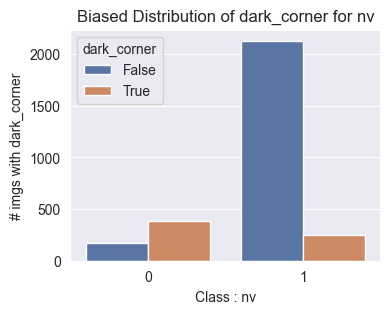

In [10]:
df_biased_1 = df_train[df_train[class_] == 1]

# Sampling by taking 20% of the images belonging to class nv without dark_corner
df_temp_0 = df_train[(df_train[class_] == 0) & (df_train[metadata] == True)]
df_temp_1 = df_train[(df_train[class_] == 0) & (df_train[metadata] == False)].sample(frac=0.2)
df_biased_0 = pd.concat([df_temp_0, df_temp_1])

num_samples = len(df_biased_0)
df_biased = pd.concat([df_biased_0, df_biased_1])
plt.figure(figsize=(4,3))
axs = sns.countplot(df_biased, x=class_, hue = metadata)
axs = axs.set(xlabel=f'Class : {class_}', ylabel=f'# imgs with {metadata}', 
        title=f'Biased Distribution of {metadata} for {class_}')

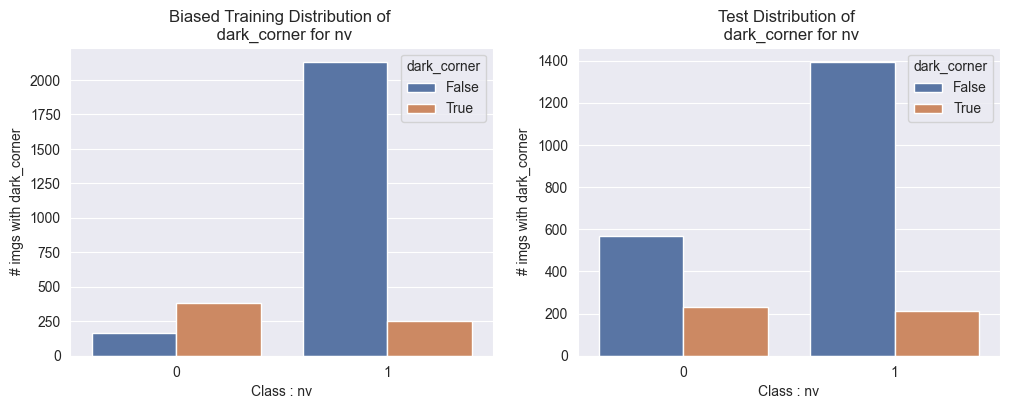

In [11]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))

axs[0] = sns.countplot(df_biased, x=class_, hue = metadata, ax = axs[0])\
            .set(xlabel=f'Class : {class_}', ylabel=f'# imgs with {metadata}', 
                title=f'Biased Training Distribution of \n {metadata} for {class_}')
axs[1] = sns.countplot(df_test, x=class_, hue = metadata, ax = axs[1])\
            .set(xlabel=f'Class : {class_}', ylabel=f'# imgs with {metadata}', 
                title=f'Test Distribution of \n {metadata} for {class_}')

In [12]:
make_dir = lambda path : os.makedirs(path) if not os.path.exists(path) else 0 

In [13]:
#save_folder = f'processed data/{metadata}/'
save_folder = f'processed data/{metadata}/'
_ = make_dir(save_folder)

df_biased.to_csv(f'{save_folder}train_biased.csv', index=False)
df_test.to_csv(f'{save_folder}test.csv', index=False)

Since we downsampled the number of images from one class, we need to ensure that for comparison we have the same number of images in that class.  
We will call this as the unbiased train set.

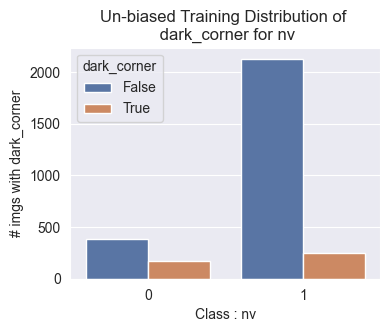

In [14]:
df_unbiased_1 = df_train[df_train[class_] == 1]
df_unbiased_0 = df_train[df_train[class_] == 0].sample(num_samples)
df_unbiased = pd.concat([df_unbiased_1, df_unbiased_0])

plt.figure(figsize=(4,3))
_ = sns.countplot(df_unbiased, x=class_, hue = metadata)\
            .set(xlabel=f'Class : {class_}', ylabel=f'# imgs with {metadata}', 
                title=f'Un-biased Training Distribution of \n {metadata} for {class_}')
plt.show()

df_unbiased.to_csv(f'{save_folder}train_unbiased.csv', index=False)